# Exporting int vectors and treemap analysis

In this notebook we try to study the influence of wasm on performances comparing to native rust.

For this test, we have two datastructures : `BTreeMap<int, usize>` and `Vector<int>`. We generate some random values that we fill in the structure, then we compute the sum of 25% of the numbers in the structure.

The sum can be computed in the datastructure, on by using an intermediate btreemap or vector.

In the notebook, V means "native vector" for vectors, T means "native tree" for trees, CV means "using an intermediate vector", CT means "using an intermediate tree". When using a tree, CV is equivalent to V in Rust, and when using a vector, CT is equivalent to T in Rust. In JS, we export to JS the intermediate tree / vector to JS (V for Tree does not explicitely exports the structure).

The used code can be found somewhere™.

**TL;DR : There is no cost to export pointless datastructures (with ints) in JS but there is a cost to running in WasmRust vs native Rust**

## Loading data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

In [2]:
d = {}

with open("intvectdataloop_2.csv", 'r') as file:
    reader = csv.reader(file)

    for row in reader:
        key = (
            row[0],
            row[1].split("-")[0],
            row[1].split("-")[1]
        )
        
        if key not in d:
            d[key] = {}
            
        size = int(row[3])
        
        if size not in d[key]:
            d[key][size] = [[], [], []]
        
        d[key][size][0].append(float(row[7])) # Gen time
        d[key][size][1].append(float(row[8])) # Fill time
        d[key][size][2].append(float(row[9])) # Sum time

def is_optimal(key):
    return (key[1] == 'IntVector' and key[2] == 'V') or (key[1] == 'IntTree' and key[2] == 'T')

# Several avg functions
def avg(l):
    l = sorted(l)
    return l[len(l) // 2]

def avg_avg(l):
    i = 0
    for x in l:
        i += x
    return i / len(l)

def avg_min(l):
    i = l[0]
    for x in l:
        i = min(i, x)
    return i


def avg_max(l):
    i = l[0]
    for x in l:
        i = max(i, x)
    return i

def avg_geom(l):
    k = 1
    for x in l:
        k = k * x
    return k ** (1 / (len(l) * 1.0))
    
    
def avg_one(l):
    return 1

# And we just use the geometric one
avg_ = avg_geom

for x in d:
    for s in d[x]:
        d[x][s][0] = avg_(d[x][s][0])
        d[x][s][1] = avg_(d[x][s][1])
        d[x][s][2] = avg_(d[x][s][2])

for x in d:
    print(str(x) + " " + str(d[x]))
    break

('JS', 'IntVector', 'V') {1000: [0.00010908069233166183, 0.0001634309248750592, 8.668926601053086e-06], 10000: [0.0012649505302238144, 0.002628749612306837, 2.3407314629470743e-05], 100000: [0.007654362728110279, 0.020859438557735248, 3.5158881539256554e-05], 1000000: [0.06544112520947343, 0.202630092269525, 0.00012252646808343274], 10000000: [0.6545572167660698, 2.368857286292561, 0.0010281922446717883]}


## Draw plot functions

In [4]:
# Selection : All, Gen, Fill or Sum

def draw_plot(selection, platforms, datastructures, tests, only_on_opt=False):
    def make_title(p, dd, t):
        zz = ""
        
        if len(platforms) != 1:
            zz += p + " "        
        if len(datastructures) != 1:
            zz += dd + " "        
        if len(tests) != 1:
            zz += t + " "
            
        return zz
    
    if only_on_opt:
        tests = ['V', 'T']
    
    for platform in platforms:
        for datastructure in datastructures:
            for test in tests:
                x = []
                y = []
                
                for entry in d:
                    if entry[0] == platform and entry[1] == datastructure and entry[2] == test:
                        if only_on_opt and not is_optimal(entry):
                            continue
                        
                        for size in d[entry]:
                            x.append(size)
                            t = 0
                            #if selection == "All" or selection == "Gen":
                            if selection == "Gen":
                                t += d[entry][size][0]
                                
                            if selection == "All" or selection == "Fill":
                                t += d[entry][size][1]
                                
                            if selection == "All" or selection == "Sum":
                                t += d[entry][size][2]
                            
                            y.append(t)
                
                if len(x) > 0:
                    plt.loglog(x, y, label=make_title(platform, datastructure, test))
                    #plt.plot(x, y, label=make_title(platform, datastructure, test))
                
    def make_title():
        zz = selection
        if len(platforms) == 1:
            zz += " " + platforms[0]
        if len(datastructures) == 1:
            zz += " " + datastructures[0]
        if len(tests) == 1:
            zz += " " + tests[0]
        return zz
        
    plt.title(make_title())
    plt.legend()
    plt.show()
    
plt.rcParams["figure.figsize"]=15,5

We study the performances of our operation (generating random numbers, filling the data structure with these numbers then computing the sum). On this first graph, we only show filling + summing

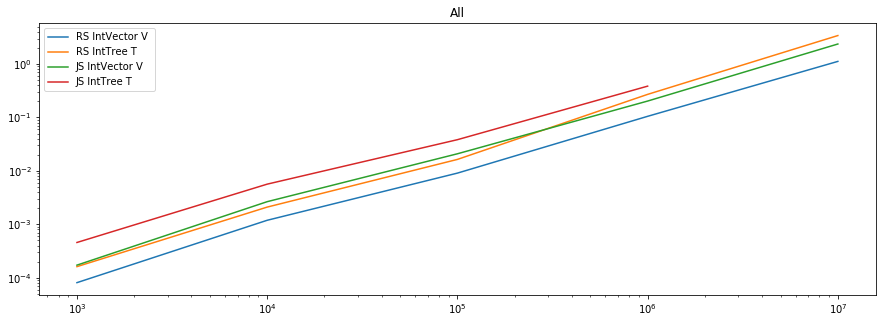

In [5]:
draw_plot("All", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'], True)

Generating random numbers doesn't depend of the target data structure but it depends on the platform (wasm or js)

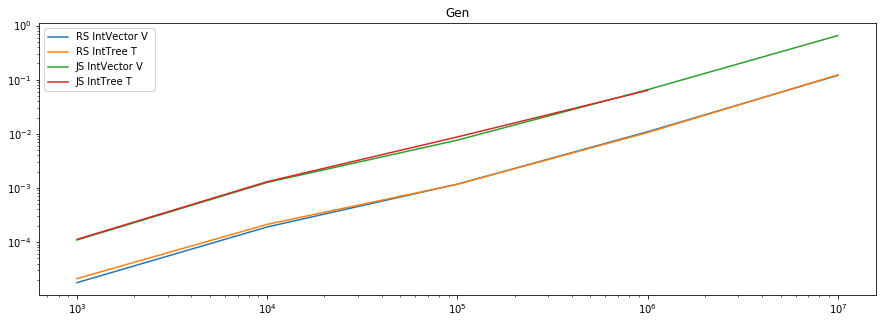

In [6]:
draw_plot("Gen", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'], True)

Filling a tree is always slower

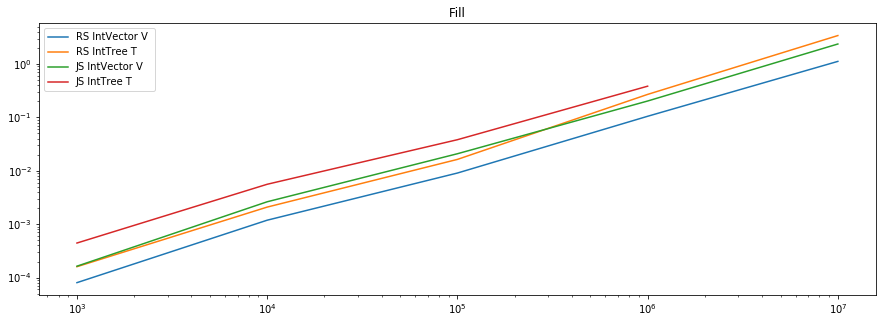

In [7]:
draw_plot("Fill", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'], True)

When computing, vector is also slower. The gap between JS and RS tends to diminish

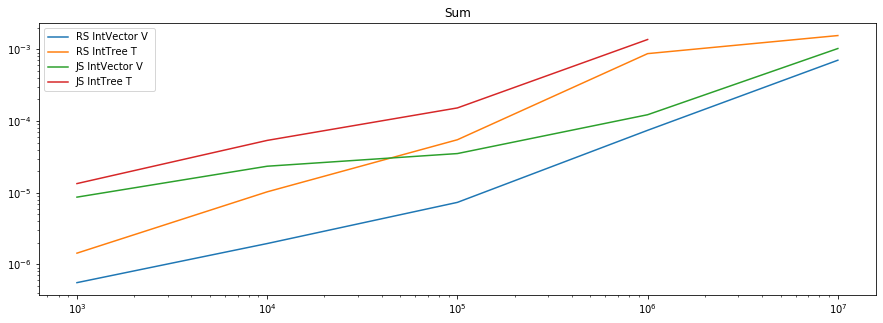

In [8]:
draw_plot("Sum", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'], True)

There is a plateau because IntTree is a Map and at some point, every number has been added so the tree's structure doesn't change anymore

## idk

Vectors : staying in a vector data structure is better


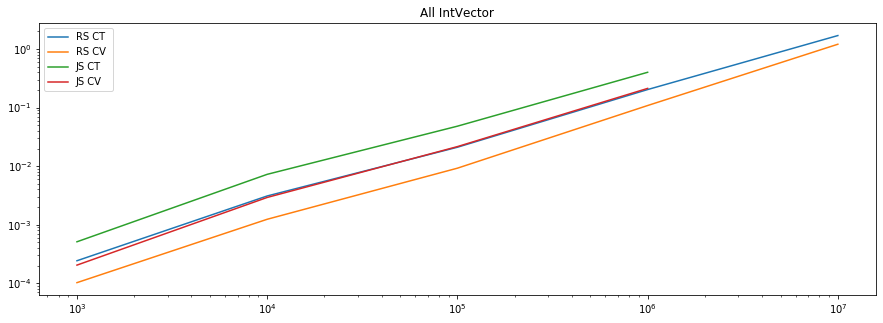

In [9]:
print("Vectors : staying in a vector data structure is better")
draw_plot("All", ["RS", "JS"], ["IntVector"], ['CT', 'CV'])
#draw_plot("Fill", ["RS", "JS"], ["IntVector"], ['CT', 'CV'])
#draw_plot("Sum", ["RS", "JS"], ["IntVector"], ['CT', 'CV'])

Tree : keeping the tree structure is the best


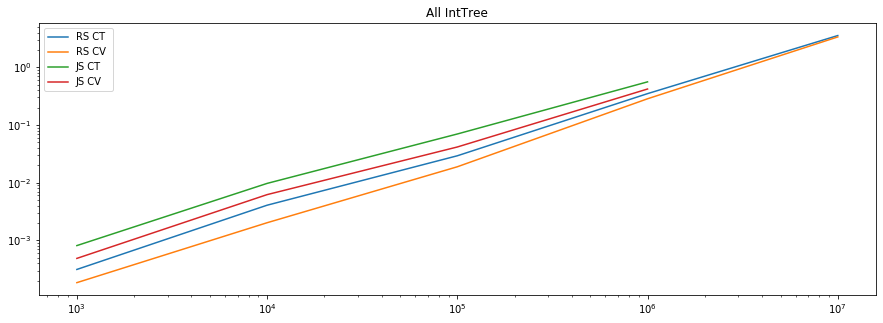

In [10]:
print("Tree : keeping the tree structure is the best")
draw_plot("All", ["RS", "JS"], ["IntTree"], ['CT', 'CV'])
#draw_plot("Fill", ["RS", "JS"], ["IntTree"], ['CV'])
#draw_plot("Sum", ["RS", "JS"], ["IntTree"], ['CV'])

Exporting the intermediate tree doesn't change anything

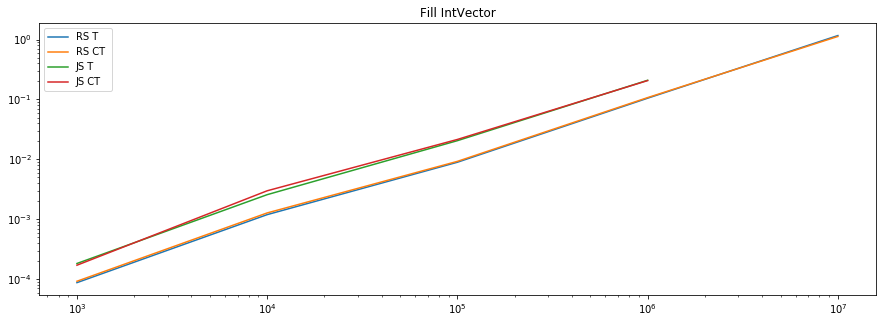

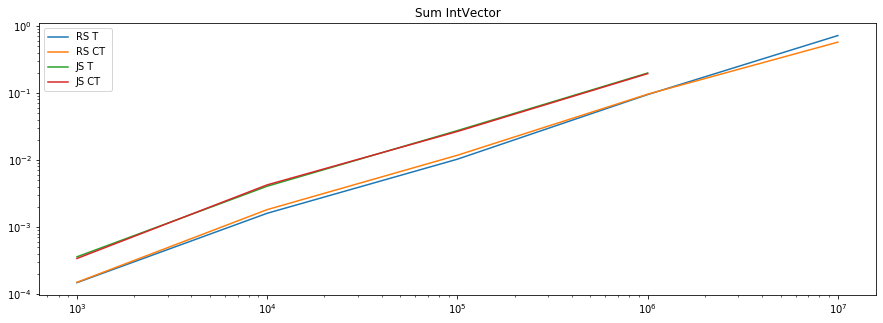

In [11]:
draw_plot("Fill", ["RS", "JS"], ["IntVector"], ['T', 'CT'])
draw_plot("Sum", ["RS", "JS"], ["IntVector"], ['T', 'CT'])

## There is no point on

### Comparing generation time

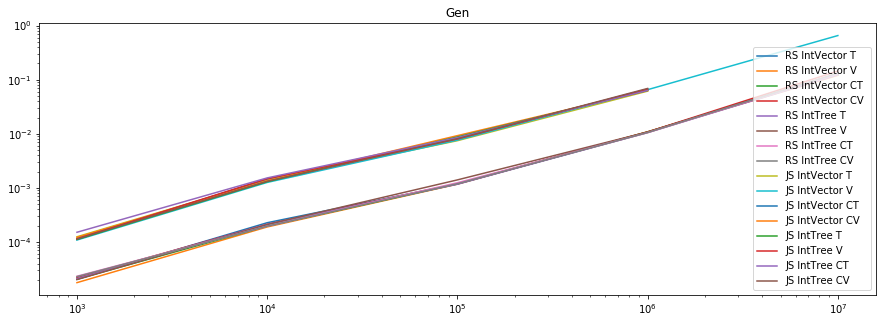

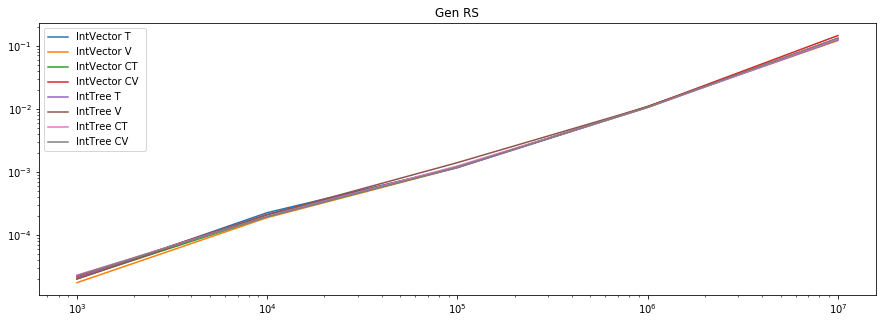

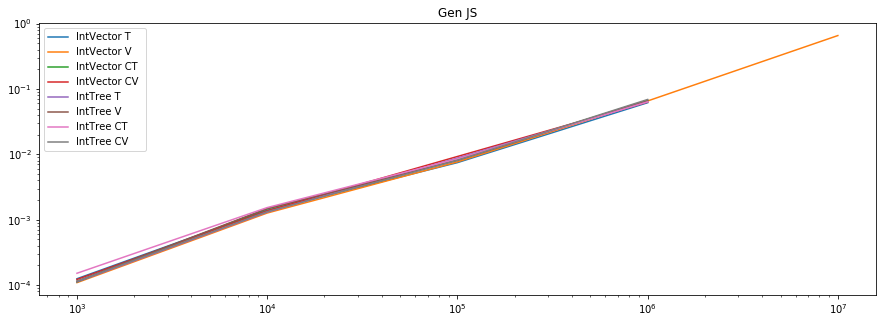

In [13]:
draw_plot("Gen", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])
draw_plot("Gen", ["RS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])
draw_plot("Gen", ["JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])

### Comparing filling time

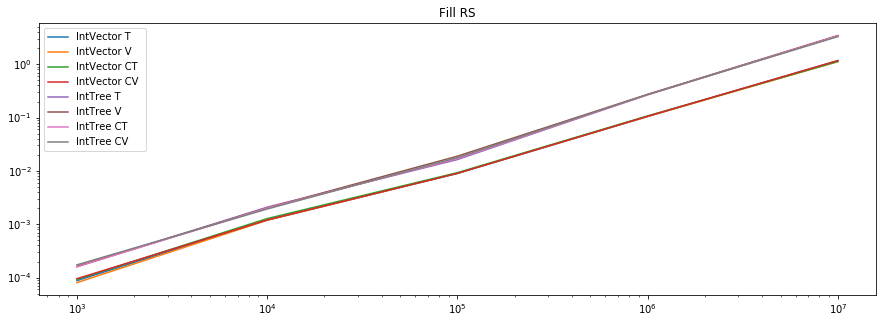

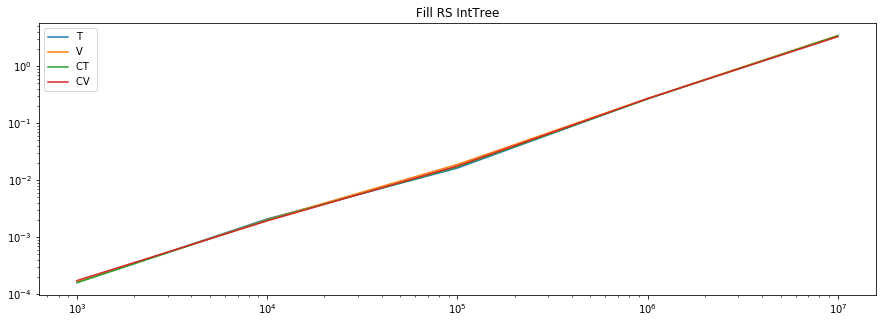

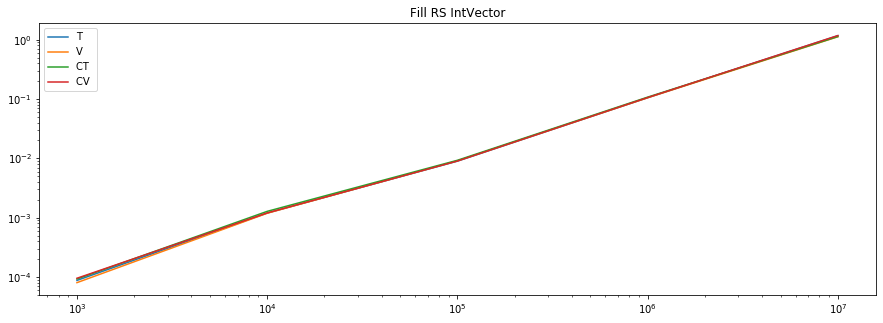

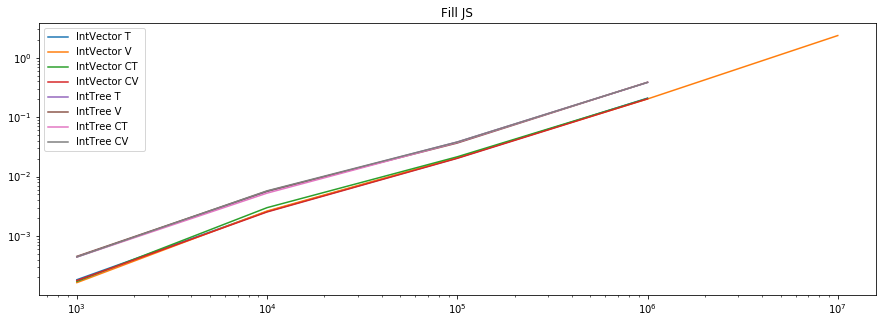

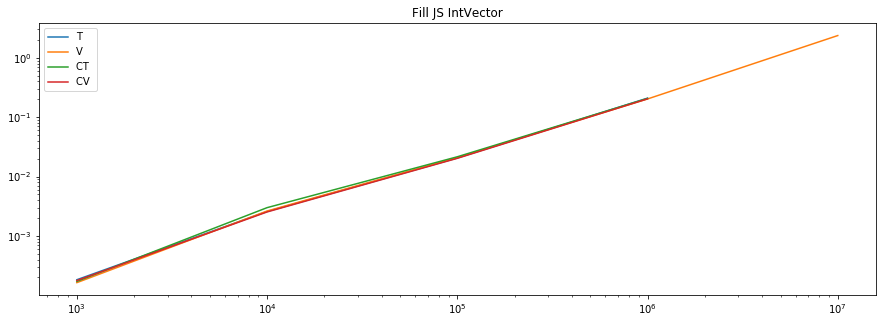

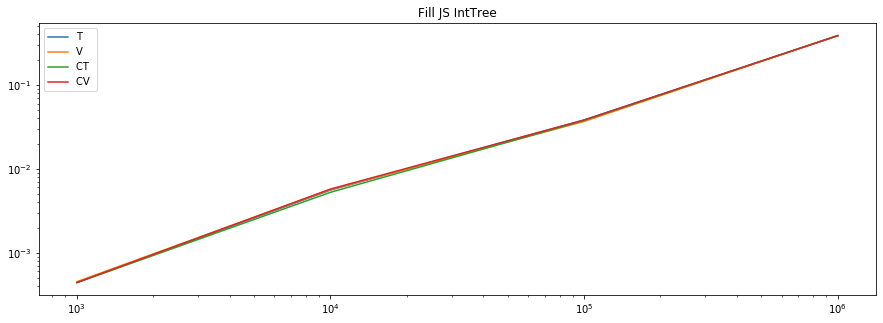

In [14]:
draw_plot("Fill", ["RS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])
draw_plot("Fill", ["RS"], ["IntTree"], ['T', 'V', 'CT', 'CV'])
draw_plot("Fill", ["RS"], ["IntVector"], ['T', 'V', 'CT', 'CV'])
draw_plot("Fill", ["JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])
draw_plot("Fill", ["JS"], ["IntVector"], ['T', 'V', 'CT', 'CV'])
draw_plot("Fill", ["JS"], ["IntTree"], ['T', 'V', 'CT', 'CV'])

## Sum of Everything

"I don't get it"

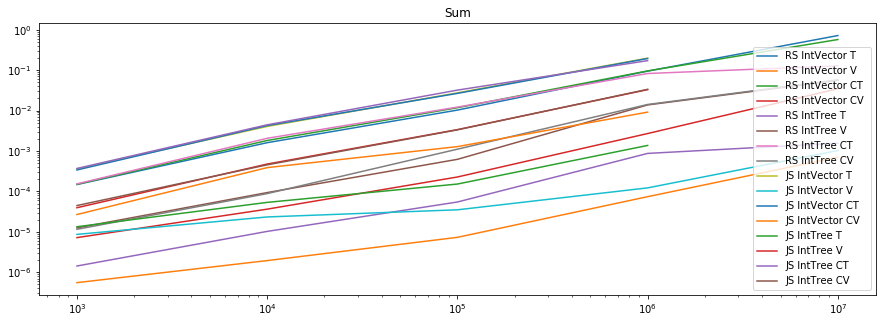

In [15]:
draw_plot("Sum", ["RS", "JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])

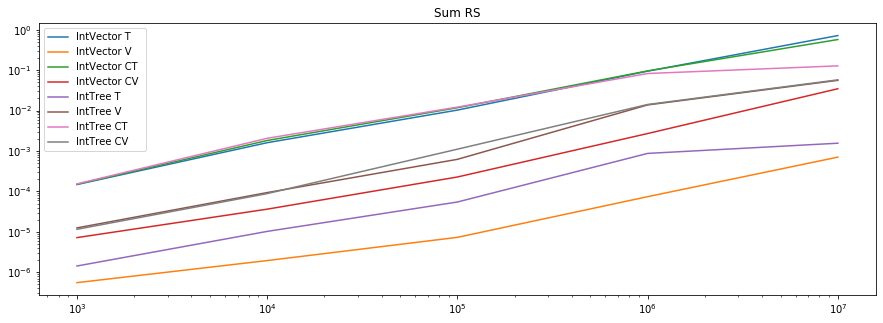

In [16]:
draw_plot("Sum", ["RS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])

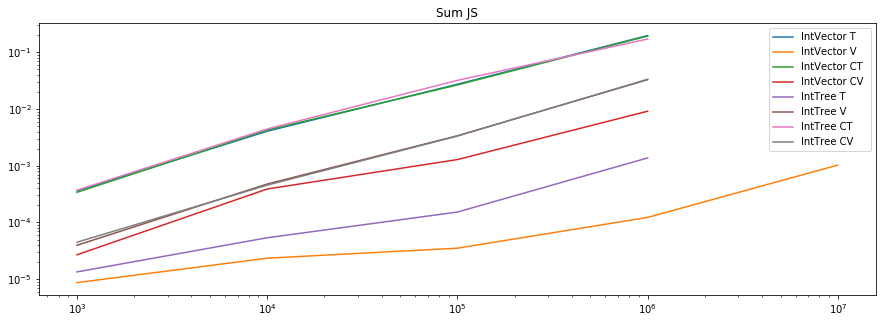

In [17]:
draw_plot("Sum", ["JS"], ["IntVector", "IntTree"], ['T', 'V', 'CT', 'CV'])

## Vectors (but it's pointless)

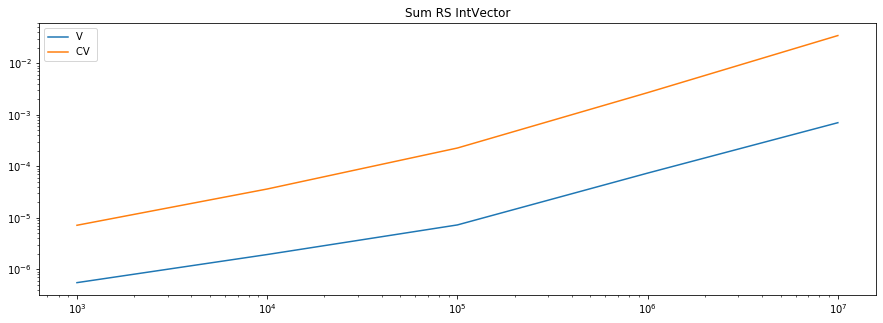

In [18]:
draw_plot("Sum", ["RS"], ["IntVector"], ['V', 'CV'])

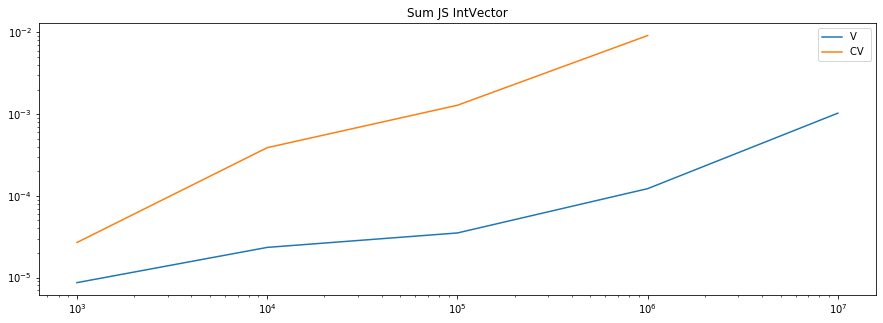

In [19]:
draw_plot("Sum", ["JS"], ["IntVector"], ['V', 'CV'])

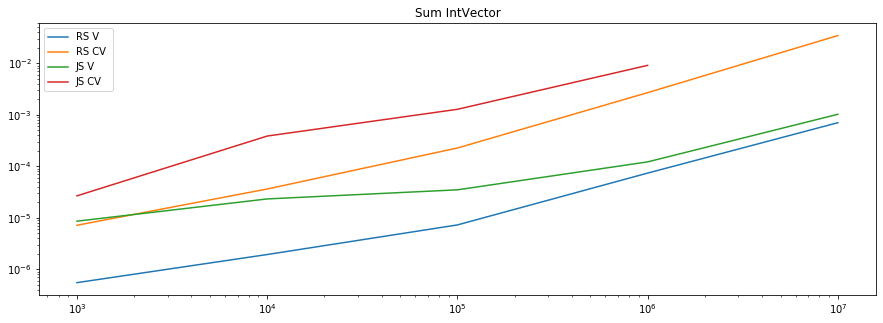

In [20]:
draw_plot("Sum", ["RS", "JS"], ["IntVector"], ['V', 'CV'])

## Overcost

IntVector : CV = export the vector to JS

JS doesn't care if it receives the intermediate tree or not

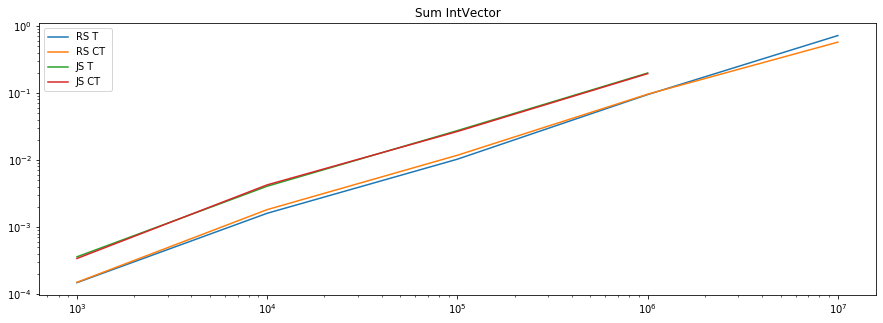

In [21]:
draw_plot("Sum", ["RS", "JS"], ["IntVector"], ['T', 'CT'])

Copying the tree always has a cost

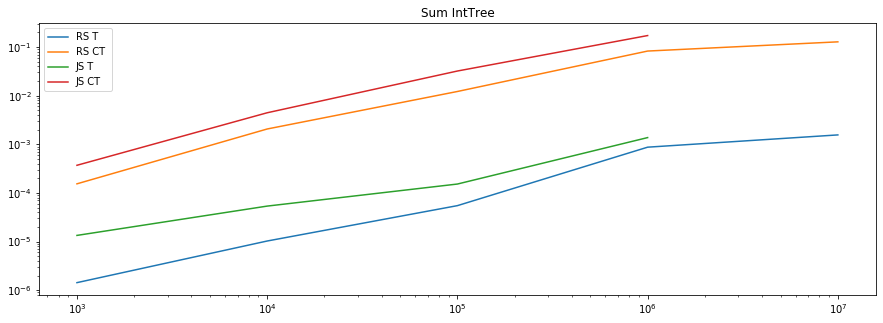

In [22]:
draw_plot("Sum", ["RS", "JS"], ["IntTree"], ['T', 'CT'])

JS doesn't care if it receives the intermediate vector

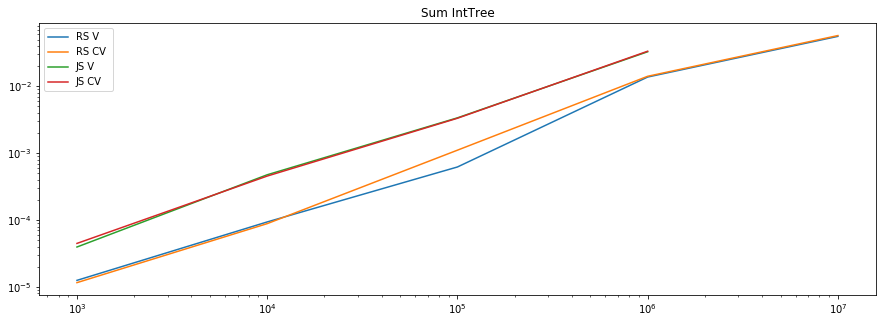

In [23]:
for method in ["Sum"]:
    draw_plot(method, ["RS", "JS"], ["IntTree"], ['V', 'CV'])

**TL;DR : There is no cost for exporting pointless vectors / trees of numbers in JS from RustWasm but there is a cost to wasm vs just running in native**